# The transient Universe

### Tasks

1. Read in solutions/transient.npy. This is a (100 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2. One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as: $$y=b,\text{ for } t<t_0$$ $$y=b+Aexp[-\alpha(t-t_0)], \text{ for } t\geq t_0$$ where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

   Code this burst model, and code a likelihood function for this data with the burst model. Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.

3. Using one of the MCMC sampler that we looked at in class (emcee, pymc), perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of ${b, A, t_0, \alpha}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b \in \text{Uniform}[0, 50]$, $A \in \text{Uniform}[0, 50]$, $t_0 \in \text{Uniform}[0, 100]$, and $ln\alpha \in \text{Uniform}[-5, 5]$  (careful: uniform in $ln\alpha$, not $\alpha$).

4. Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5. Make a corner plot of the 4-D parameter space, with labels, $[68-95]\%$ credible levels and quantiles, and titles.

6. Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7. For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance, $X_{-Z}^{+Y}$.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
from scipy.optimize import minimize

data = np.load("../solutions/transient.npy")
# The first column is time (arbitrary units), the second column is flux (arbitrary units), 
# the third column are homoescedastic measurement uncertainties on the flux.

time = np.array(data[:, 0])
flux = np.array(data[:, 1])
flux_error = np.array(data[:, 2])

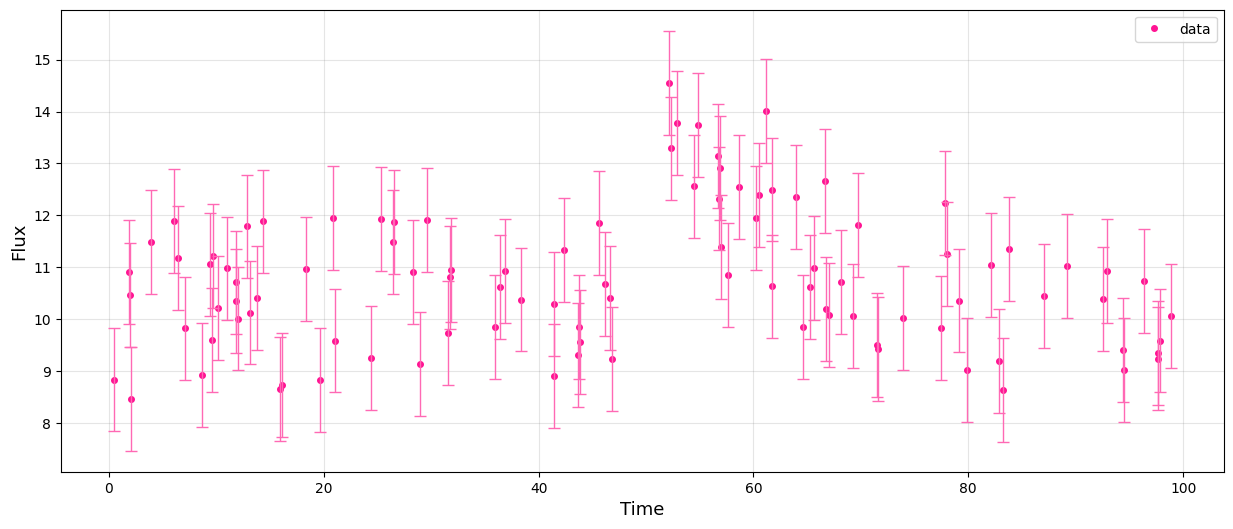

In [2]:
plt.figure(figsize=(15, 6))
plt.plot(time, flux, lw = 0.5, ls = '', c = 'deeppink', marker = 'o', markersize = 4, label = 'data')
plt.errorbar(time, flux, yerr=flux_error, fmt = 'none', linewidth = 1, c = 'hotpink', capsize = 4)
plt.xlabel('Time', fontsize = 13)
plt.ylabel('Flux', fontsize = 13)
plt.legend(loc='best')
plt.grid(color='grey', alpha = 0.2)
plt.show()

In [3]:
def model(theta, t):
    A, b, t0, alpha = theta
    return np.where(t < t0, b, b+A*np.exp(-alpha*(t-t0)))

def lnLikelihood(theta, t, f, err_f):
    f_model = model(theta, t)
    return -0.5 * np.sum((f-f_model)**2/(err_f**2))

def lnPrior(theta):
    A, b, t0, alpha = theta
    
    Amin, Amax = 0, 50
    bmin, bmax = 0, 50
    t0min, t0max = 0, 100
    alphamin, alphamax = np.exp(-5), np.exp(5)
    
    if Amin < A < Amax and bmin < b < bmax and t0min < t0 < t0max and alphamin < alpha < alphamax:
        return np.log(1/alpha)
    return -np.inf

def lnPosterior(theta, t, f, err_f):
    return lnLikelihood(theta, t, f, err_f) + lnPrior(theta)

We can start by eyeballing the parameters and then using those guesses as a starting point for a MLE using scipy.optimize.minimize. 

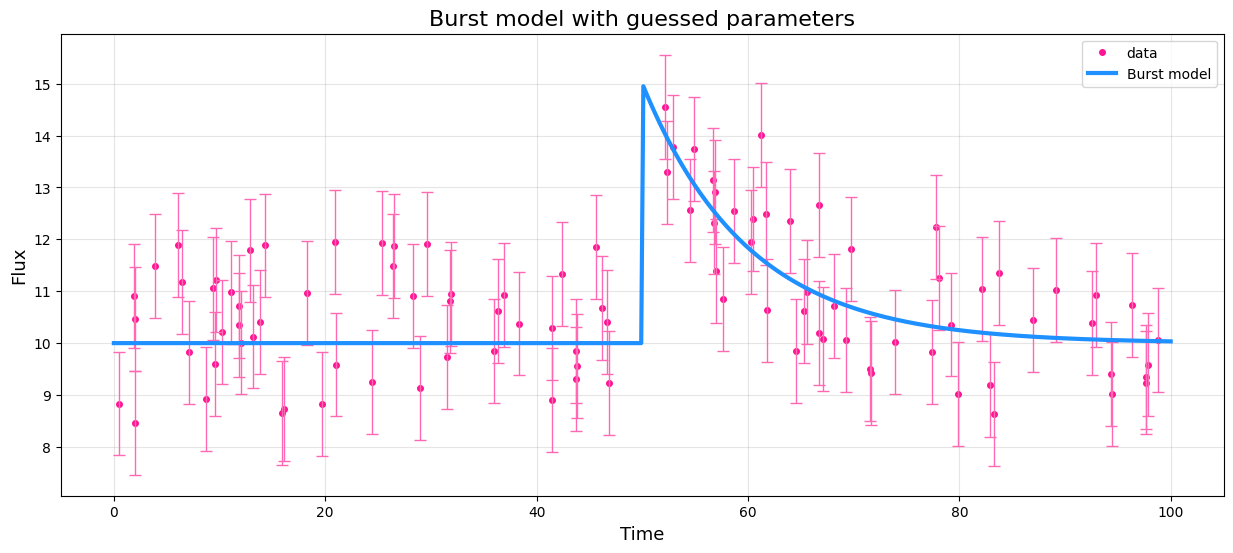

In [4]:
# Initial guess for the parameters
A_i = 5
b_i = 10
t0_i = 50
alpha_i = 0.1

par_i = np.array([A_i, b_i, t0_i, alpha_i])

tgrid = np.linspace(0, 100, 500)
guessed_modelpoints = np.empty(shape=tgrid.shape)

for i, t in enumerate(tgrid):
    guessed_modelpoints[i] = model(par_i, t)

plt.figure(figsize=(15, 6))
plt.plot(time, flux, lw = 0.5, ls = '', c = 'deeppink', marker = 'o', markersize = 4, label = 'data')
plt.errorbar(time, flux, yerr=flux_error, fmt = 'none', linewidth = 1, c = 'hotpink', capsize = 4)
plt.plot(tgrid, guessed_modelpoints, lw = 3, c = 'dodgerblue', label = 'Burst model')
plt.xlabel('Time', fontsize = 13)
plt.ylabel('Flux', fontsize = 13)
plt.title('Burst model with guessed parameters', fontsize = 16)
plt.legend(loc='best')
plt.grid(color='grey', alpha = 0.2)
plt.show()

PARAMETER	INITIAL GUESS	MLE
A		5.00		4.95
b		10.00		10.29
t_0		50.00		49.97
alpha		0.10		0.12


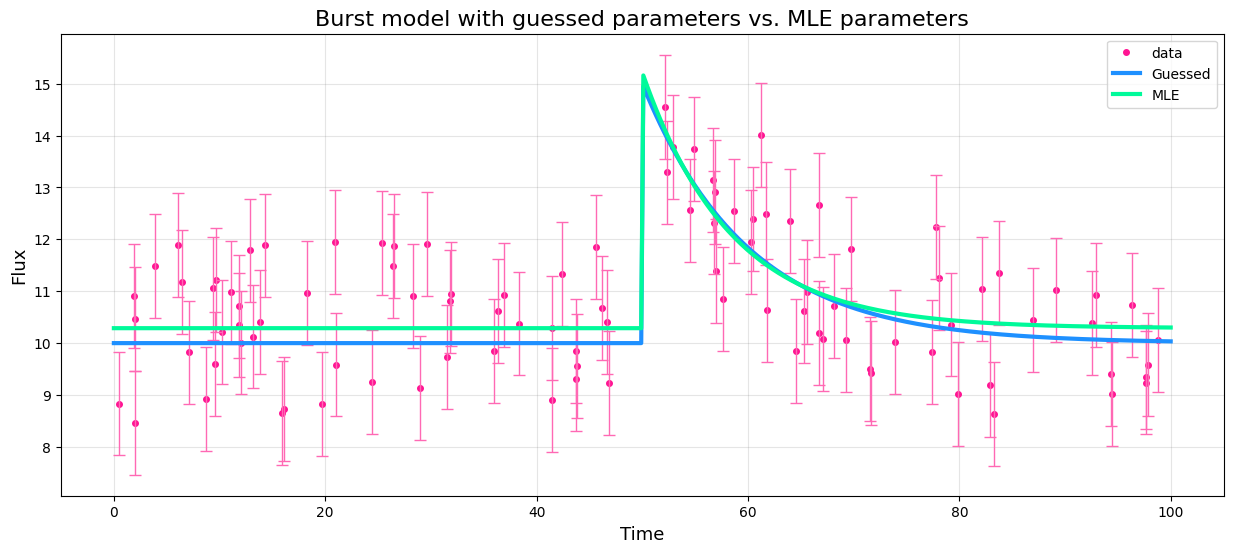

In [5]:
# Finding the parameters with a MLE

# I want to minimize the negative log likelihood, using the initial guesses from before for the parameters.
def neg_lnL(theta, t, f, err_f):
    return -lnLikelihood(theta, t, f, err_f)

result = minimize(neg_lnL, par_i, args=(time, flux, flux_error), bounds=[(0, 50), (0, 50), (0, 100), (np.exp(-5), np.exp(5))])
A_mle, b_mle, t0_mle, alpha_mle = result.x
par_mle = np.array([A_mle, b_mle, t0_mle, alpha_mle])

print("PARAMETER\tINITIAL GUESS\tMLE")
print("A\t\t%.2f\t\t%.2f" % (A_i, A_mle))
print("b\t\t%.2f\t\t%.2f" % (b_i, b_mle))
print("t_0\t\t%.2f\t\t%.2f" % (t0_i, t0_mle))
print("alpha\t\t%.2f\t\t%.2f" % (alpha_i, alpha_mle))

mle_modelpoints = np.empty(shape=tgrid.shape)

for i, t in enumerate(tgrid):
    mle_modelpoints[i] = model(par_mle, t)

plt.figure(figsize=(15, 6))
plt.plot(time, flux, lw = 0.5, ls = '', c = 'deeppink', marker = 'o', markersize = 4, label = 'data')
plt.errorbar(time, flux, yerr=flux_error, fmt = 'none', linewidth = 1, c = 'hotpink', capsize = 4)
plt.plot(tgrid, guessed_modelpoints, lw = 3, c = 'dodgerblue', label = 'Guessed')
plt.plot(tgrid, mle_modelpoints, lw = 3, c = 'Mediumspringgreen', label = 'MLE')
plt.xlabel('Time', fontsize = 13)
plt.ylabel('Flux', fontsize = 13)
plt.title('Burst model with guessed parameters vs. MLE parameters', fontsize = 16)
plt.legend(loc='best')
plt.grid(color='grey', alpha = 0.2)
plt.show()

In [51]:
ndim = 4     # 4 parameters
nwalkers = 20
burn = 1000
nsteps = 50000

# To initialize each parameter for the walkers, I'm gonna extract from a standard Gaussian shifted to be centered in the MLE value and with a 
# standard deviation of 0.1 (I tried using the Fisher matrix errors but they were too big, so I'm eyeballing it and adjusting it as I go).

starting_guesses = par_mle + np.random.normal(loc=0, scale=0.1, size=(nwalkers, ndim))
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnPosterior, args=[time, flux, flux_error])
sampler.run_mcmc(starting_guesses, nsteps, progress = True)

samples = sampler.get_chain()
print(sampler.chain.shape)     # (nwalkers x nsteps x ndim)
print(samples.shape)     # (nsteps x nwalkers x ndim)

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:02<00:00, 802.42it/s]

(20, 50000, 4)
(50000, 20, 4)


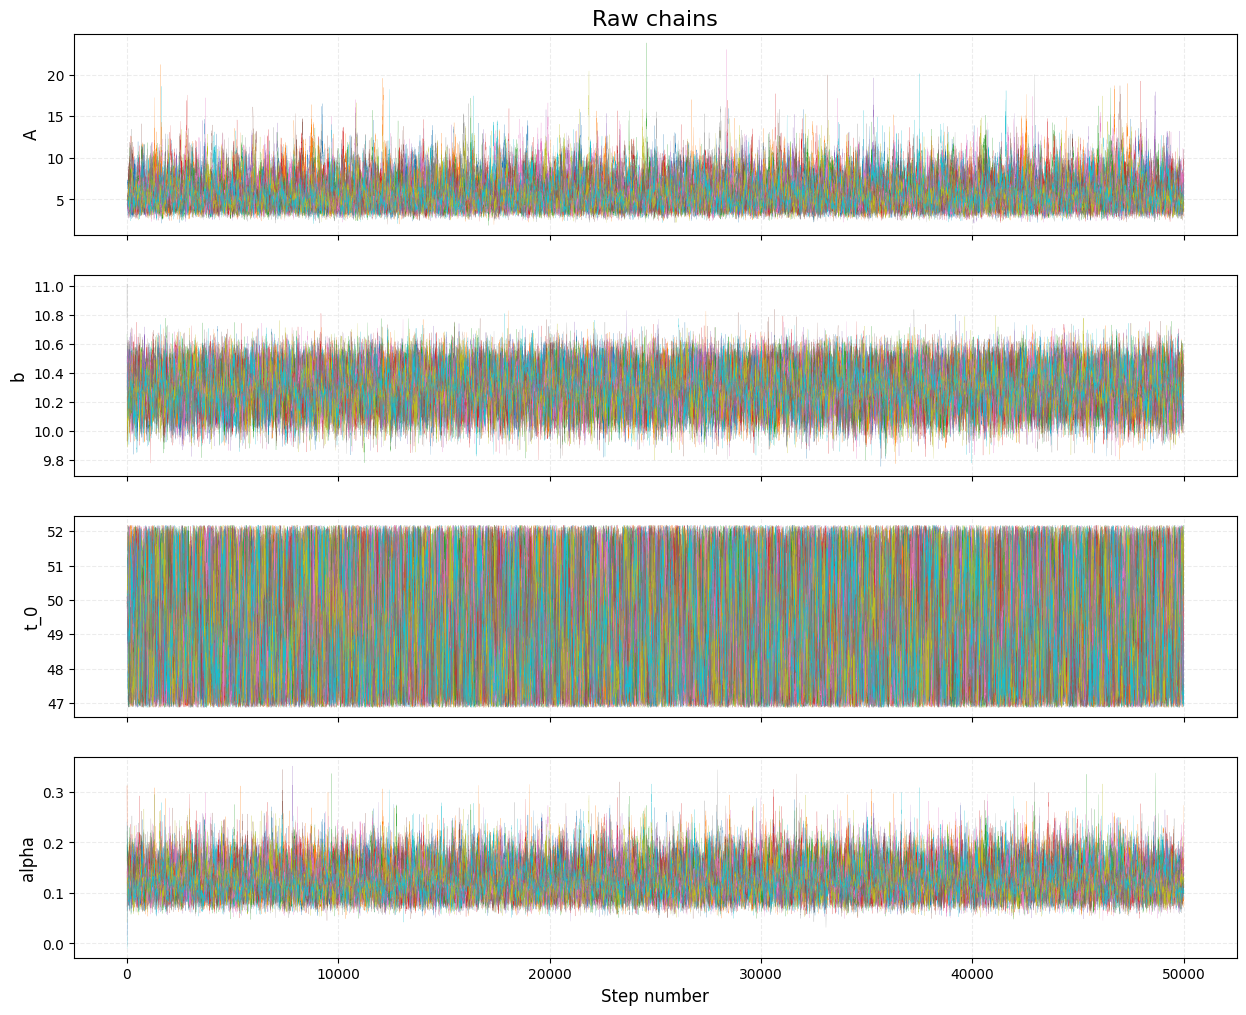

In [52]:
# Visualizing, for each parameter, the different walkers WITHOUT the burn-in

fig, axes = plt.subplots(4, figsize=(15, 12), sharex=True)
params = ["A", "b", "t_0", "alpha"]

for i in range(ndim):
    ax = axes[i]
    for j in range(nwalkers):
        ax.plot(samples[:, j, i], lw = 0.1)
        ax.set_ylabel(params[i], fontsize=12)
        ax.grid(c='grey', alpha=0.15, ls='--')

axes[-1].set_xlabel('Step number', fontsize=12)
axes[0].set_title('Raw chains', fontsize=16)
plt.show()

(980000, 4)
[81.59483941 59.60542523 81.97710859 67.07755171]
(12080, 4)


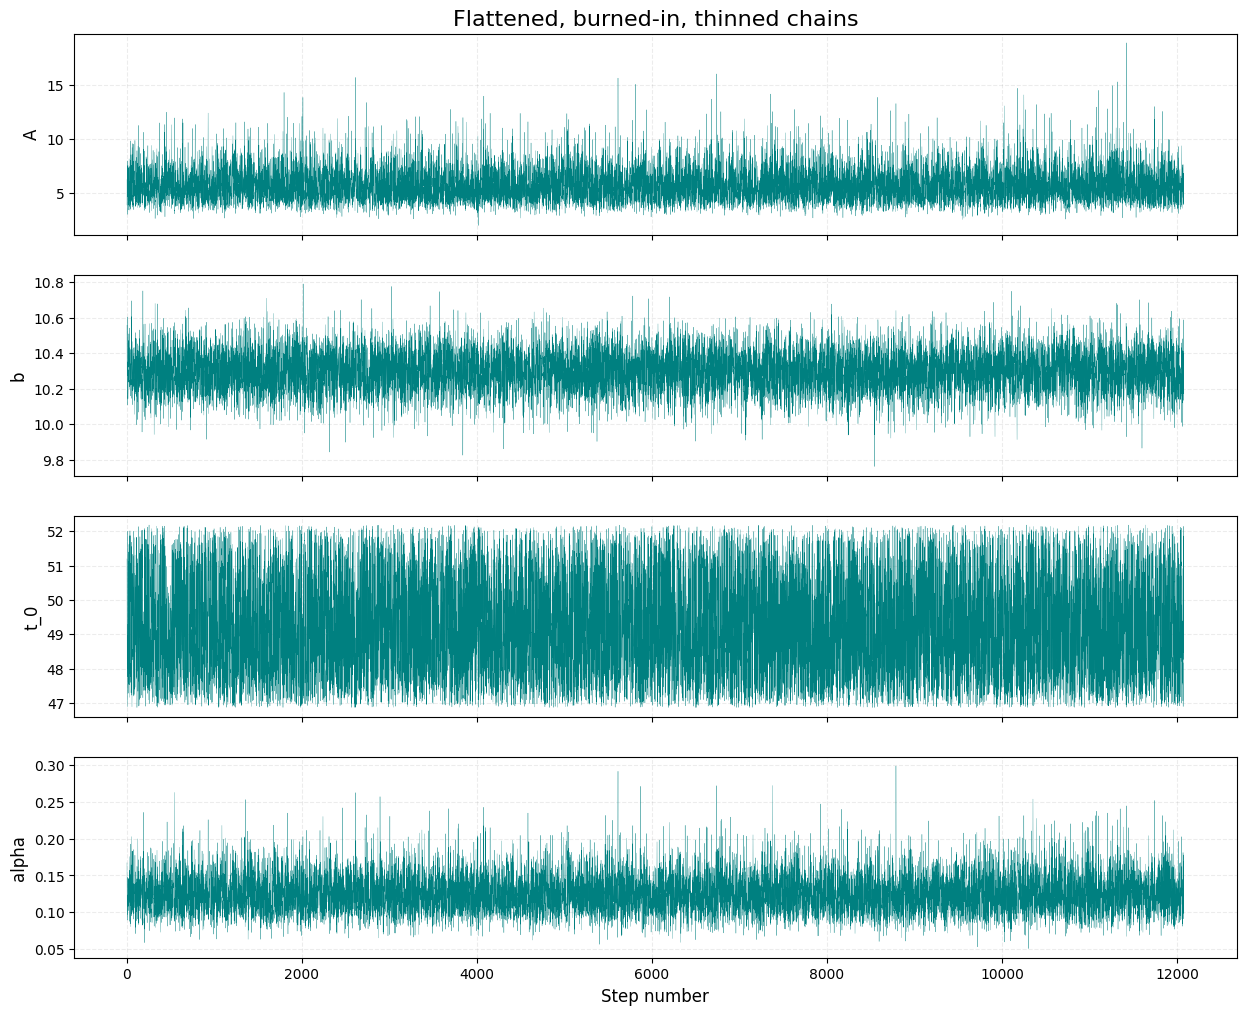

In [56]:
# Flattened, burned-in, thinned chains
tau = sampler.get_autocorr_time()
print(tau)

flat_samples = sampler.get_chain(discard=burn, thin=int(max(tau)), flat=True)
print(flat_samples.shape)

fig, axes = plt.subplots(4, figsize=(15, 12), sharex=True)
params = ["A", "b", "t_0", "alpha"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(flat_samples[:, i], lw = 0.2, c='teal')
    ax.set_ylabel(params[i], fontsize=12)
    ax.grid(c='grey', alpha=0.15, ls='--')

axes[-1].set_xlabel('Step number', fontsize=12)
axes[0].set_title('Flattened, burned-in, thinned chains', fontsize=16)
plt.show()